# Simulación de Vectores Aleatorios

### Método de Aceptación–Rechazo para Vectores Aleatorios

A continuación se presenta el método de Metropolis-Hasting para simular **vectores aleatorios continuos** en dos dimensiones. Para consultar la prueba y una discusión sobre este método, se puede ver la página web [Algoritmo de Metropolis Hastings](https://www.dpye.iimas.unam.mx/eduardo/mcb/node26.html).

**Pseudo-Código para simular distribuciones conjuntas**

Supongamos que:

- $f(x,y)$ es la densidad objetivo.  
- $q((x',y') \mid (x,y))$ es la densidad de propuesta.
- Tenemos un punto inicial $(x_0, y_0) \in \mathbb{R}^2$.

Entonces:

1. Elegimos un punto inicial $(x_0, y_0)$.  
2.  Fijamos el número de iteraciones y el número total de muestras deseadas.
3. Para cada iteración $k = 0,1,2,\ldots$, simulamos una propuesta
   $$
   (x', y') \sim q((\cdot,\cdot) \mid (x_k, y_k)).
   $$
4. Calculamos la razón de aceptación
   $$
   r = \frac{f(x',y')}{f(x_k,y_k)} \cdot
       \frac{q((x_k,y_k)\mid (x',y'))}{q((x',y')\mid (x_k,y_k))}.
   $$

5. Simulamos $U \sim U(0,1)$.

4. Si $U \le \min\{1, r\}$, aceptar: $(x_{k+1}, y_{k+1}) = (x', y')$. En caso contrario, regresamos al paso 3.

Programemos este método

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [55]:
def metropolis_hastings_2d(f, n_muestras=1, n_iter=1000, tamano_paso=1.0, x0=None):
    """
    f: función de densidad conjunta f(x, y)
    n_muestras: número de realizaciones deseadas.
    n_iter: número de iteraciones iniciales
    tamaño_paso: desviación estándar de la propuesta normal.
    x0: punto inicial (si None, inicia en (0,0)).
    """

    # En caso de que x0 sea None
    if x0 is None:
        x = np.array([0.0, 0.0])
    else:
        x = np.array(x0, dtype=float)

    # Lista para guardar las muestras
    muestras = []

    # Metropolis-Hastings
    for i in range(n_iter + n_muestras):
        # propuesta: normal centrada en x
        propuesta = x + np.random.normal(scale=tamano_paso, size=2)

        # razón de aceptación
        f_actual = f(x[0], x[1])
        f_propuesta = f(propuesta[0], propuesta[1])

        if f_propuesta <= 0: # invalida si f<0
            accept = False
        else:
            prop = f_propuesta / f_actual
            accept = (np.random.rand() < min(1, prop))

        # mover o no
        if accept:
            x = propuesta

        # guardar después de terminar
        if i >= n_iter:
            muestras.append(x.copy())

    return np.array(muestras)


Ahora veamos algunos ejemplos con distribucioens conjuntas

In [38]:
def f_demo(x, y):
    return np.exp(-(x**2 + y**2) / 2)

samples = metropolis_hastings_2d(f_demo, n_muestras=1)
print(samples[0])


[-0.37370022  1.80121751]


Ahora haremos una clase para almacenar este procedimiento y una función para graficar muestras de distribuciones conjuntas.

Ahora juntamos todo esto en una sola clase

In [45]:
class Metropolis:

    def __init__(self, f, paso=1.0, x0=None):
      '''
      f: función de densidad conjunta f(x, y)
      paso: desviación estándar de la propuesta normal.
      x0: punto inicial (si None, inicia en (0,0)).
      '''
      self.f = f
      self.paso = paso
      self.x = np.array([0.0, 0.0]) if x0 is None else np.array(x0, dtype=float)

    def sample(self, n_muestras=1, n_iter=1000):
        muestras = []

        for i in range(n_iter + n_muestras):
            propuesta = self.x + np.random.normal(scale=self.paso, size=2)

            f_actual = self.f(self.x[0], self.x[1])
            f_propuesta = self.f(propuesta[0], propuesta[1])

            if f_propuesta > 0:
                prop = f_propuesta / f_actual
                accept = (np.random.rand() < min(1, prop))
            else:
                accept = False

            if accept:
                self.x = propuesta

            if i >= n_iter:
                muestras.append(self.x.copy())

        return np.array(muestras)


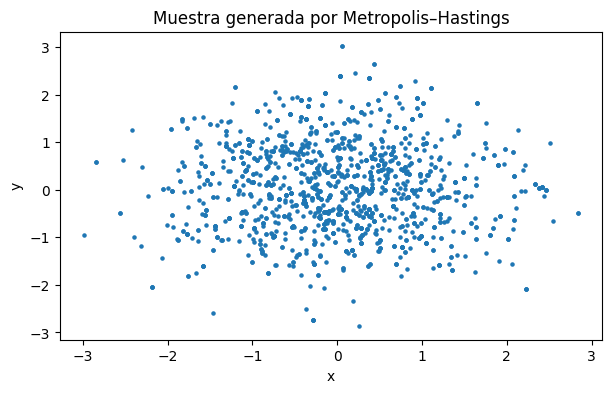

In [49]:
def graficar(f, n=2000, paso=1.0, x0=None):
    muestrero = Metropolis(f, paso=paso, x0=x0)
    samples = muestrero.sample(n_muestras=n)

    x, y = samples[:,0], samples[:,1]
    plt.figure(figsize=(7, 4))
    plt.scatter(x, y, s=5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Muestra generada por Metropolis–Hastings")
    plt.show()

# Ejemplo 1
def f_example(x, y):
    return np.exp(-(x**2 + y**2)/2)

graficar(f_example, n=1500, paso=1.0)

Veamos ejemplos con algunas funciones de densidad

[[ 1.23218046 -0.9890979 ]]


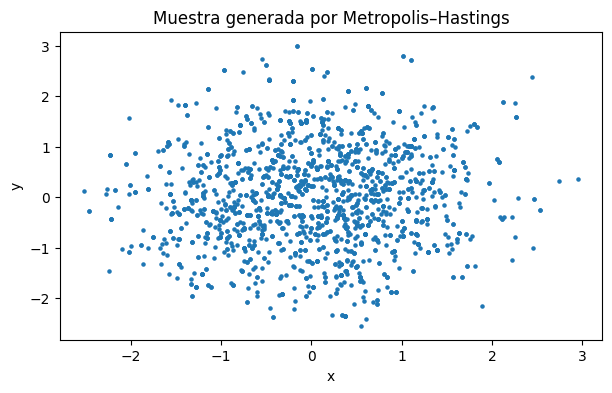

In [51]:
def f1(x, y):
    return np.exp(-(x**2 + y**2)/2)

sampler1 = Metropolis(f1, paso=1.0)
print(sampler1.sample(1))
graficar(f1, 2000, paso = 1)


[[ 9.69866332 14.9083659 ]]


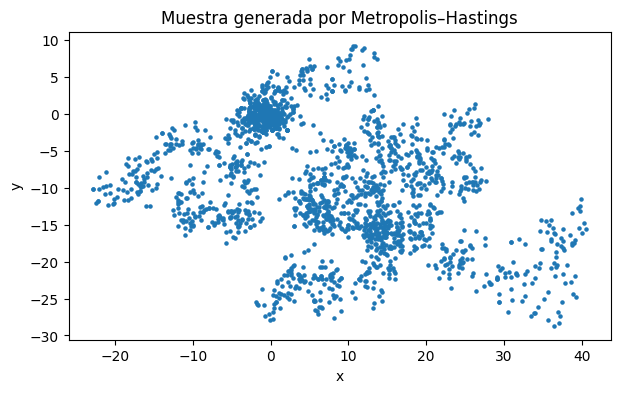

In [50]:
def f2(x, y):
    return 1 / (1 + x**2 + y**2)

sampler2 = Metropolis(f2, paso=1.5)
print(sampler2.sample(1))
graficar(f2, 2000, paso = 1)


[[-0.80950118 -2.5785011 ]]


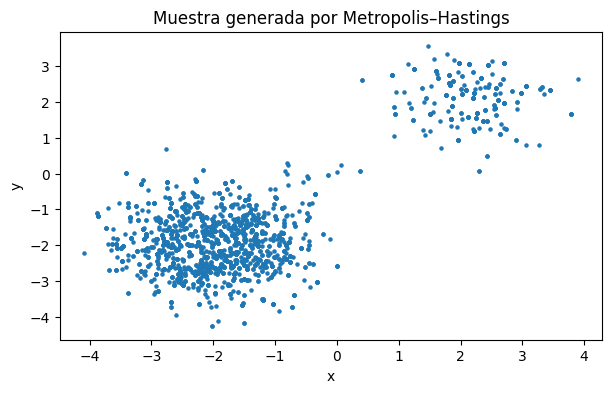

In [52]:
def f3(x, y):
    # suma de dos gaussianas
    g1 = np.exp(-((x+2)**2 + (y+2)**2))
    g2 = np.exp(-((x-2)**2 + (y-2)**2))
    return g1 + g2

sampler3 = Metropolis(f3, paso=2.0)
print(sampler3.sample(1))
graficar(f3, 2000, paso = 1)


[[1.50464274 0.38327045]]


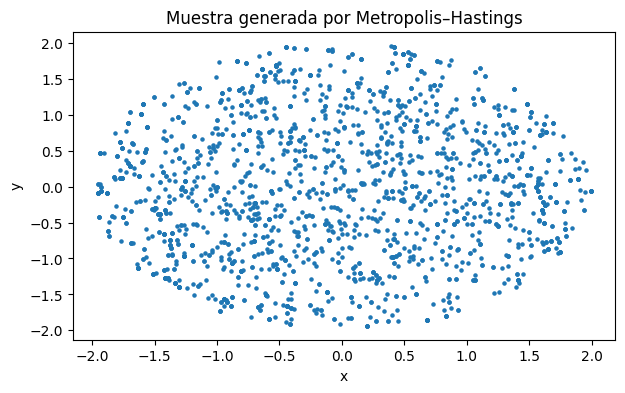

In [53]:
def f4(x, y):
    return 1.0 if (x**2 + y**2 <= 4) else 0.0

sampler4 = Metropolis(f4, paso=1.0, x0=[1,0])
print(sampler4.sample(1))
graficar(f4, 2000, paso = 1)

[[0.46495262 0.13357388]]


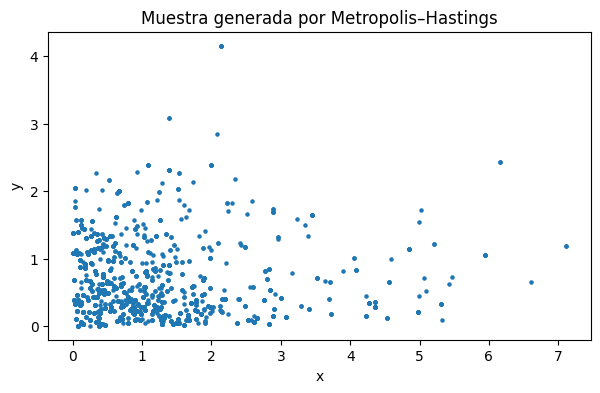

In [54]:
def f5(x, y):
    if x >= 0 and y >= 0:
        return np.exp(-x - 2*y)
    else:
        return 0.0

sampler5 = Metropolis(f5, paso=0.5, x0=[1,1])
print(sampler5.sample(1))
graficar(f5, 2000, paso = 1)